In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 100

In [298]:
# review = pd.read_csv('AZ_review.csv')
business = pd.read_json('yelp_academic_dataset_business.json', lines=True)

In [302]:
# filter businesses by opened AZ restaurants
AZ = business[business.state=='AZ']
AZ = AZ[~AZ.categories.isnull()] # drop the 199 nan categories
AZ = AZ[AZ.is_open==1] # remove closed businesses
AZrest = AZ[AZ.categories.str.contains('Restaurants')]
AZrest = AZrest.reset_index(drop=True)
del business, AZ

In [303]:
# filter reviews to restaurants in opened AZ restaurants
AZrest['stars_avg'] = AZrest.stars
AZrest = AZrest.drop('stars',1)

In [58]:
AZreview = AZrest.merge(review, on='business_id')
AZreview = AZreview[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars',
       'text', 'useful', 'user_id']]
AZreview.date = pd.to_datetime(AZreview.date)
del review

In [59]:
%who

AZrest	 AZreview	 AZreview_test	 AZreview_train	 chg_75th	 chg_80th	 chg_90th	 dataset	 first	 
np	 open_business	 open_business_2yrs	 open_business_firstyr	 open_business_secondyr	 pd	 plt	 revCount	 rev_count_secondyr_70th	 
rev_count_secondyr_75th	 rev_count_secondyr_90th	 second	 stars_50th	 target	 


#### Thoughts
- cut off earlier years since it wouldn't help us predict future virality (2014-)
- split train (2014-2017) and test data (2018 Jan-June)
    - if we trained training data wouldn't predicting Dec 2017 and Jan 2018 give us the same answer?
        - yes it would. this is what lee meant by "this is an easy problem"
- pivot: look at first year business was open to predict how it would do the second year
    - we want to predict which ones would do well the second year 
    - the years don't matter

In [104]:
# AZreview_train = AZreview[(AZreview.date.dt.year>=2006) & (AZreview.date.dt.year<2018)]
AZreview_train = AZreview[(AZreview.date.dt.year>=2006) & (AZreview.date<'05/01/2018')]

In [105]:
AZreview_train.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,8-NRKkPY1UiFXW20WXKiXg,0,2015-09-06,0,LW6IUxib0XZoYY0wS184zA,1,A ROACH crawled out of my Carne Asada fries. I...,3,KmyTD4-ms_Qbwn4fR5mWfw


### Generating target variable

In [106]:
revCount = AZreview_train.groupby([AZreview_train.business_id, AZreview_train.date.dt.month, AZreview_train.date.dt.year]).count()[['review_id']]
revCount.index = revCount.index.set_names(['business_id', 'month', 'year'])
revCount = revCount.rename(columns={'review_id':'rev_count'})
revCount = revCount.reset_index()

# avg stars
avgStars = AZreview_train.groupby([AZreview_train.business_id, AZreview_train.date.dt.month, AZreview_train.date.dt.year]).mean()[['stars']]
avgStars.index = avgStars.index.set_names(['business_id', 'month', 'year'])
avgStars = avgStars.rename(columns={'stars':'stars_month_avg'})
avgStars = avgStars.reset_index()
revCount = revCount.merge(avgStars,on=['business_id','month','year'])
del avgStars

# sum stars
sumStars = AZreview_train.groupby([AZreview_train.business_id, AZreview_train.date.dt.month, AZreview_train.date.dt.year]).sum()[['stars']]
sumStars.index = sumStars.index.set_names(['business_id', 'month', 'year'])
sumStars = sumStars.rename(columns={'stars':'stars_sum'})
sumStars = sumStars.reset_index()
revCount = revCount.merge(sumStars,on=['business_id','month','year'])
del sumStars

# add day in order to conver to datetime
revCount['day'] = 1
revCount['date'] = pd.to_datetime(revCount[['year','month','day']])

# add count of months with reviews
activity = revCount.groupby('business_id').count()
activity= activity.rename(index=str, columns={'month':'months_with_rev'})
revCount = revCount.join(activity['months_with_rev'], on='business_id')
del activity

# add total review count by business
totalrev = revCount.groupby('business_id').sum()
totalrev = totalrev.rename(index=str, columns={'rev_count':'business_rev_count'})
revCount = revCount.join(totalrev['business_rev_count'], on='business_id')
del totalrev

# add business open date
open_date = revCount.groupby(['business_id']).min()
open_date = open_date.rename(index=str, columns={'date':'open_date'})
revCount = revCount.join(open_date['open_date'], on='business_id')
display(revCount.head(1))
del open_date

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date
0,-01XupAWZEXbdNbxNg5mEg,1,2011,1,3.0,3,1,2011-01-01,54,82,2009-09-01


In [107]:
print('Total number of businesses: {}'.format(revCount.business_id.nunique()))

Total number of businesses: 7490


In [109]:
# Number of businesses by open date
revCount[revCount.date==revCount.open_date].open_date.value_counts().sort_index()

2006-01-01     61
2006-02-01     36
2006-03-01     14
2006-04-01     14
2006-05-01     13
2006-06-01     15
2006-07-01     16
2006-08-01     46
2006-09-01     37
2006-10-01     26
2006-11-01     18
2006-12-01     29
2007-01-01     57
2007-02-01     78
2007-03-01    108
2007-04-01     42
2007-05-01     41
2007-06-01     48
2007-07-01     60
2007-08-01     64
2007-09-01     33
2007-10-01     29
2007-11-01     24
2007-12-01     45
2008-01-01     55
2008-02-01     67
2008-03-01     77
2008-04-01     69
2008-05-01     62
2008-06-01     67
2008-07-01     62
2008-08-01     68
2008-09-01     52
2008-10-01     51
2008-11-01     45
2008-12-01     40
2009-01-01     66
2009-02-01     46
2009-03-01     75
2009-04-01     47
2009-05-01     47
2009-06-01     49
2009-07-01     62
2009-08-01     53
2009-09-01     46
2009-10-01     45
2009-11-01     50
2009-12-01     52
2010-01-01     46
2010-02-01     47
             ... 
2014-03-01     66
2014-04-01     61
2014-05-01     61
2014-06-01     44
2014-07-01

### Look at first year business opened compared to second year

In [122]:
open_business = revCount[revCount.open_date>='2007-01-01'] # makes sure that actual open date is within dataset
# does not include open date since it could be partial month
open_business_firstyr = open_business[(open_business.date>open_business.open_date) & (open_business.date<=open_business.open_date+pd.DateOffset(years=1))]
open_business_secondyr = open_business[(open_business.date>open_business.open_date+pd.DateOffset(years=1)) & (open_business.date<=open_business.open_date+pd.DateOffset(years=2))]
display(open_business_firstyr.head(1))

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date
7,-01XupAWZEXbdNbxNg5mEg,2,2010,2,4.0,8,1,2010-02-01,54,82,2009-09-01


In [159]:
# join first and second year
first = open_business_firstyr[['business_id','rev_count','stars_sum']].groupby('business_id').sum()
first = first.rename(index=str, columns={'rev_count':'rev_count_firstyr', 'stars_sum':'stars_sum_firstyr'})
first['stars_firstyr_avg'] = first.stars_sum_firstyr/first.rev_count_firstyr
first = first.drop('stars_sum_firstyr',1)
second = open_business_secondyr[['business_id','rev_count','stars_sum']].groupby('business_id').sum()
second = second.rename(index=str, columns={'rev_count':'rev_count_secondyr', 'stars_sum':'stars_sum_secondyr'})
second['stars_secondyr_avg'] = second.stars_sum_secondyr/second.rev_count_secondyr
second = second.drop('stars_sum_secondyr',1)
open_business_2yrs = first.join(second)
# add change
open_business_2yrs['chg'] = open_business_2yrs.rev_count_secondyr/open_business_2yrs.rev_count_firstyr-1
open_business_2yrs.head(1)

,rev_count_firstyr,stars_firstyr_avg,rev_count_secondyr,stars_secondyr_avg,chg
business_id,,,,,
-01XupAWZEXbdNbxNg5mEg,8,3.25,6.0,3.166667,-0.25


In [162]:
# look at percentiles
display(open_business_2yrs.describe(percentiles=[.55,.6,.65,.7,.75,.8,.85,.9,.95]))
rev_count_secondyr_50th = open_business_2yrs['rev_count_secondyr'].describe(percentiles=[.70,.9,.95]).loc['50%']
rev_count_secondyr_70th = open_business_2yrs['rev_count_secondyr'].describe(percentiles=[.70,.9,.95]).loc['70%']
rev_count_secondyr_75th = open_business_2yrs['rev_count_secondyr'].describe(percentiles=[.75,.9,.95]).loc['75%']
rev_count_secondyr_90th = open_business_2yrs['rev_count_secondyr'].describe(percentiles=[.75,.9,.95]).loc['90%']
chg_50th = open_business_2yrs['chg'].describe(percentiles=[.65,.9,.95]).loc['50%']
chg_65th = open_business_2yrs['chg'].describe(percentiles=[.65,.9,.95]).loc['65%']
chg_70th = open_business_2yrs['chg'].describe(percentiles=[.70,.9,.95]).loc['70%']
chg_75th = open_business_2yrs['chg'].describe(percentiles=[.75,.9,.95]).loc['75%']
chg_90th = open_business_2yrs['chg'].describe(percentiles=[.75,.9,.95]).loc['90%']
chg_60th = open_business_2yrs['chg'].describe(percentiles=[.6,.8,.95]).loc['60%']
stars_50th = open_business_2yrs['stars_secondyr_avg'].describe(percentiles=[.75,.8,.95]).loc['50%']

,rev_count_firstyr,stars_firstyr_avg,rev_count_secondyr,stars_secondyr_avg,chg
count,5860.000000,5860.000000,4743.000000,4743.000000,4743.000000
mean,25.130887,3.580604,20.275353,3.529343,0.428285
std,44.127108,1.001987,33.520461,0.977330,1.563995
min,1.000000,1.000000,1.000000,1.000000,-0.988235
50%,6.000000,3.800000,7.000000,3.750000,0.000000
55.0%,8.000000,3.948767,9.000000,3.849082,0.000000
60%,11.000000,4.000000,11.000000,4.000000,0.125185
65%,15.000000,4.000000,14.000000,4.000000,0.287000
70%,21.000000,4.142857,18.000000,4.083333,0.500000
75%,30.000000,4.274521,23.000000,4.200000,0.672619


In [163]:
# filter by business the review count greater than 75th percentile in year 2 with growth in review count greater than 75th percentile growth.
open_business_2yrs = open_business_2yrs.sort_values('chg', ascending=False)
target = open_business_2yrs[(open_business_2yrs.rev_count_secondyr >= rev_count_secondyr_70th) & 
                   (open_business_2yrs.chg >= chg_60th) & 
                   (open_business_2yrs.stars_secondyr_avg >= stars_50th)].sort_values('rev_count_firstyr', ascending=False)
target.index.values.shape

(306,)

In [164]:
target.head()

,rev_count_firstyr,stars_firstyr_avg,rev_count_secondyr,stars_secondyr_avg,chg
business_id,,,,,
Xg5qEQiB-7L6kGJ5F4K3bQ,266,4.770677,434.0,4.783410,0.631579
L2p0vO3fsS2LC6hhQo3CzA,231,4.147186,281.0,3.992883,0.216450
NgDyxaeItFSInv7J5paGLQ,223,4.264574,255.0,4.227451,0.143498
FsCujpVh9Za2Dl5MIYLCxA,207,4.497585,258.0,4.624031,0.246377
thLX_k20SPJ0KyusGTBIHw,198,4.085859,283.0,4.130742,0.429293


### Check Target Restaurants to see if it meets our criterias

In [375]:
AZrest[AZrest.business_id=='1I555FApTVfQA9QR9GyIMg']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,state,stars_avg
4485,4437 E Southern Ave,"{'HasTV': 'False', 'Alcohol': 'none', 'Ambienc...",1I555FApTVfQA9QR9GyIMg,"Delis, Sandwiches, Salad, Restaurants",Mesa,"{'Wednesday': '10:0-15:0', 'Tuesday': '10:0-15...",1,33.391957,-111.735687,Greenfield's Deli,,85206,20,AZ,4.0


In [192]:
# Target Restaurants
AZrest[AZrest.business_id.isin(target.index)].sort_values('review_count',ascending=False)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,state,stars_avg
2751,7210 E 2nd St,"{'HappyHour': 'True', 'BestNights': '{'monday'...",3l54GTr8-E3XPbIxnF_sAA,"American (New), Burgers, Nightlife, Bars, Sand...",Scottsdale,"{'Wednesday': '11:0-22:0', 'Monday': '11:0-21:...",1,33.491503,-111.925627,Rehab Burger Therapy,,85251,1958,AZ,4.5
2766,"3000 E Ray Rd, Bldg 1","{'RestaurantsGoodForGroups': 'True', 'Caters':...",0FUtlsQrJI7LhqDPxLumEw,"Pizza, Italian, American (Traditional), Restau...",Gilbert,"{'Wednesday': '8:0-21:0', 'Monday': '8:0-21:0'...",1,33.321824,-111.726057,Joe's Farm Grill,,85296,1884,AZ,4.0
1178,4301 E University Dr,"{'RestaurantsGoodForGroups': 'True', 'Ambience...",Xg5qEQiB-7L6kGJ5F4K3bQ,"Barbeque, Restaurants",Phoenix,"{'Friday': '11:0-16:0', 'Wednesday': '11:0-16:...",1,33.421877,-111.989344,Little Miss BBQ,,85034,1746,AZ,5.0
4850,"7111 E 5th Ave, Ste E","{'RestaurantsGoodForGroups': 'True', 'Wheelcha...",d10IxZPirVJlOSpdRZJczA,"Nightlife, Restaurants, American (New), Gastro...",Scottsdale,"{'Wednesday': '16:0-23:0', 'Monday': '16:0-23:...",1,33.498210,-111.927963,Citizen Public House,,85251,1722,AZ,4.5
5596,825 N 1st St,"{'RestaurantsGoodForGroups': 'True', 'Wheelcha...",L2p0vO3fsS2LC6hhQo3CzA,"Breakfast & Brunch, Restaurants",Phoenix,"{'Wednesday': '6:30-14:30', 'Monday': '6:30-14...",1,33.457448,-112.072295,Matt's Big Breakfast,,85004,1698,AZ,4.0
4435,"960 W University Dr, Ste 103","{'HappyHour': 'True', 'BestNights': '{'monday'...",wl0QZqAzr1DelslQ02JGCQ,"Bars, Restaurants, Pubs, Caterers, British, Ev...",Tempe,"{'Wednesday': '11:0-0:0', 'Monday': '11:0-0:0'...",1,33.423059,-111.951843,Cornish Pasty,,85281,1585,AZ,4.5
3958,13623 N 32nd St,"{'RestaurantsGoodForGroups': 'True', 'Wheelcha...",E4JyAzB5_2quptwtemyhYA,"Breakfast & Brunch, Burgers, Seafood, Restaura...",Phoenix,"{'Wednesday': '6:30-14:0', 'Monday': '6:30-14:...",1,33.610804,-112.012836,Original Breakfast House,,85032,1269,AZ,4.5
6851,230 N Gilbert Rd,"{'RestaurantsGoodForGroups': 'True', 'Caters':...",3N9U549Zse8UP-MwKZAjAQ,"Food, Coffee & Tea, Restaurants, Local Flavor,...",Gilbert,"{'Wednesday': '7:0-21:0', 'Monday': '7:0-21:0'...",1,33.354768,-111.789833,Liberty Market,,85234,1260,AZ,4.0
6144,"8390 E Via De Ventura, Ste F-108","{'RestaurantsGoodForGroups': 'True', 'Caters':...",Iq7NqQD-sESu3vr9iEGuTA,"Waffles, Breakfast & Brunch, Coffee & Tea, Res...",Scottsdale,"{'Wednesday': '6:30-14:30', 'Monday': '6:30-14...",1,33.554825,-111.899636,Butters Pancakes & Café,,85258,1167,AZ,4.5
6610,"721 N Arizona Ave, Ste 103","{'RestaurantsGoodForGroups': 'True', 'Caters':...",sJNcipFYElitBrtiJx0ezQ,"Food, Breweries, American (New), Burgers, Rest...",Gilbert,"{'Wednesday': '11:0-23:0', 'Monday': '11:0-23:...",1,33.362962,-111.841142,Arizona Wilderness Brewing,,85233,1137,AZ,4.0


### Build dataset with target variable for training & testing

In [165]:
dataset = open_business_firstyr
dataset = dataset.reset_index(drop=True)
dataset['target'] = 0
dataset['target'][dataset.business_id.isin(target.index)] = 1

/Users/justinmae/anaconda/envs/introds/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [166]:
dataset.head()

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date,target
0,-01XupAWZEXbdNbxNg5mEg,2,2010,2,4.000000,8,1,2010-02-01,54,82,2009-09-01,0
1,-01XupAWZEXbdNbxNg5mEg,3,2010,1,3.000000,3,1,2010-03-01,54,82,2009-09-01,0
2,-01XupAWZEXbdNbxNg5mEg,8,2010,1,2.000000,2,1,2010-08-01,54,82,2009-09-01,0
3,-01XupAWZEXbdNbxNg5mEg,10,2009,3,3.333333,10,1,2009-10-01,54,82,2009-09-01,0
4,-01XupAWZEXbdNbxNg5mEg,11,2009,1,3.000000,3,1,2009-11-01,54,82,2009-09-01,0


In [167]:
# number of target businesses
dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)].target.sum()

230

In [168]:
# total number of businesses
dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)].target.count()

3010

In [169]:
# target variable percentage
dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)].target.sum() / dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)].target.count()

0.07641196013289037

### 12-03-18
- increased sample size
- use second month to 13th month, since 1st month may not be full month

#### Thoughts
- what is trend in terms of reviews / month?

In [193]:
dataset.head()

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date,target
0,-01XupAWZEXbdNbxNg5mEg,2,2010,2,4.000000,8,1,2010-02-01,54,82,2009-09-01,0
1,-01XupAWZEXbdNbxNg5mEg,3,2010,1,3.000000,3,1,2010-03-01,54,82,2009-09-01,0
2,-01XupAWZEXbdNbxNg5mEg,8,2010,1,2.000000,2,1,2010-08-01,54,82,2009-09-01,0
3,-01XupAWZEXbdNbxNg5mEg,10,2009,3,3.333333,10,1,2009-10-01,54,82,2009-09-01,0
4,-01XupAWZEXbdNbxNg5mEg,11,2009,1,3.000000,3,1,2009-11-01,54,82,2009-09-01,0


In [195]:
# distribution of number of months with reviews in first year for all businesses
dataset.groupby('business_id').count().iloc[:,0].value_counts().sort_index()

1     1232
2      869
3      529
4      412
5      330
6      274
7      221
8      211
9      206
10     249
11     355
12     972
Name: month, dtype: int64

In [173]:
dataset[dataset.business_id=='-0WegMt6Cy966qlDKhu6jA'].sort_values('date')

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date,target
9,-0WegMt6Cy966qlDKhu6jA,5,2013,2,3.00,6,1,2013-05-01,33,79,2013-04-01,0
10,-0WegMt6Cy966qlDKhu6jA,6,2013,4,2.25,9,1,2013-06-01,33,79,2013-04-01,0
11,-0WegMt6Cy966qlDKhu6jA,7,2013,4,2.50,10,1,2013-07-01,33,79,2013-04-01,0
12,-0WegMt6Cy966qlDKhu6jA,8,2013,1,1.00,1,1,2013-08-01,33,79,2013-04-01,0
13,-0WegMt6Cy966qlDKhu6jA,9,2013,5,2.20,11,1,2013-09-01,33,79,2013-04-01,0
14,-0WegMt6Cy966qlDKhu6jA,10,2013,1,3.00,3,1,2013-10-01,33,79,2013-04-01,0
6,-0WegMt6Cy966qlDKhu6jA,1,2014,1,1.00,1,1,2014-01-01,33,79,2013-04-01,0
7,-0WegMt6Cy966qlDKhu6jA,2,2014,1,3.00,3,1,2014-02-01,33,79,2013-04-01,0
8,-0WegMt6Cy966qlDKhu6jA,4,2014,2,2.00,4,1,2014-04-01,33,79,2013-04-01,0


In [196]:
# distribution of number of months with reviews in first year for target businesses
dataset[(dataset.target==1)].sort_values('date').groupby('business_id').count().iloc[:,0].value_counts().sort_index()

1      2
2      6
3     10
4      8
5      8
6     23
7     20
8     27
9     30
10    36
11    41
12    95
Name: month, dtype: int64

In [175]:
dataset[(dataset.target==1) & (dataset.business_id=='j0_DUr3vBXY-JP-b0bf93A')].sort_values('date') 
dataset[(dataset.target==1)].sort_values('date') 
dataset[(dataset.target==1) & (dataset.business_id=='vQq_sX0kSAUdT3yLW06q5A')].sort_values('date') 

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date,target


In [178]:
# dataset_l3m = 
dataset[(dataset.date > dataset.open_date+pd.DateOffset(months=9)) & (dataset.business_id=='vQq_sX0kSAUdT3yLW06q5A')]
# dataset_l6m = dataset[(dataset.date>dataset.open_date+pd.DateOffset(months=6)) & (dataset.business_id=='vQq_sX0kSAUdT3yLW06q5A')]
# dataset_l9m = 
# dataset[(dataset.date>dataset.open_date+pd.DateOffset(months=3)) & (dataset.business_id=='vQq_sX0kSAUdT3yLW06q5A')]
# dataset_l12m = 
# dataset[(dataset.business_id=='vQq_sX0kSAUdT3yLW06q5A')]

,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date,target
30405,vQq_sX0kSAUdT3yLW06q5A,1,2014,10,4.000000,40,1,2014-01-01,64,358,2013-01-01,0
30415,vQq_sX0kSAUdT3yLW06q5A,11,2013,9,4.666667,42,1,2013-11-01,64,358,2013-01-01,0
30416,vQq_sX0kSAUdT3yLW06q5A,12,2013,5,4.600000,23,1,2013-12-01,64,358,2013-01-01,0


### Add features to final dataset

In [223]:

dataset_l3m = dataset[(dataset.date>dataset.open_date+pd.DateOffset(months=9))]
dataset_l6m = dataset[(dataset.date>dataset.open_date+pd.DateOffset(months=6))]
dataset_l9m = dataset[(dataset.date>dataset.open_date+pd.DateOffset(months=3))]
dataset_l12m = dataset

# create data_prepped with open_date, target
# data_prepped = dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)][['business_id','open_date','target']]
# don't use target for results
data_prepped = dataset[dataset.date==dataset.open_date+pd.DateOffset(months=1)][['business_id','open_date']]
data_prepped.shape

# add l12m data - num of months with rev
rev_avg_l12m = dataset_l12m.groupby('business_id').count()[['month']]
# rev_avg_l12m.index = rev_avg_l12m.index.set_names(['business_id', 'num_months_with_rev'])
rev_avg_l12m = rev_avg_l12m.rename(columns={'month':'num_months_with_rev'})
rev_avg_l12m = rev_avg_l12m.reset_index()
data_prepped = data_prepped.merge(rev_avg_l12m,on=['business_id'])
del rev_avg_l12m
data_prepped.shape

# last 12 month features
rev_avg_l12m = dataset_l12m.groupby('business_id').sum()[['rev_count', 'stars_sum']]
rev_avg_l12m = rev_avg_l12m.rename(columns={'rev_count':'rev_count_l12m', 'stars_sum':'stars_sum_l12m'})
rev_avg_l12m = rev_avg_l12m.reset_index()
data_prepped = data_prepped.merge(rev_avg_l12m,on=['business_id'])
del rev_avg_l12m
data_prepped['stars_avg_l12m'] = data_prepped.stars_sum_l12m / data_prepped.rev_count_l12m
data_prepped = data_prepped.drop('stars_sum_l12m',1)

data_prepped.shape

# last 9 month features
rev_avg_l9m = dataset_l9m.groupby('business_id').sum()[['rev_count', 'stars_sum']]
rev_avg_l9m = rev_avg_l9m.rename(columns={'rev_count':'rev_count_l9m', 'stars_sum':'stars_sum_l9m'})
rev_avg_l9m = rev_avg_l9m.reset_index()
data_prepped = data_prepped.merge(rev_avg_l9m, how='left', on=['business_id'])
del rev_avg_l9m
data_prepped['stars_avg_l9m'] = data_prepped.stars_sum_l9m / data_prepped.rev_count_l9m
data_prepped = data_prepped.drop('stars_sum_l9m',1)
# handle nulls
data_prepped['rev_count_l9m'][data_prepped.rev_count_l9m.isnull()] = 0
data_prepped['stars_avg_l9m'][data_prepped.stars_avg_l9m.isnull()] = data_prepped.stars_avg_l12m

# last 6 month features
rev_avg_l6m = dataset_l6m.groupby('business_id').sum()[['rev_count', 'stars_sum']]
rev_avg_l6m = rev_avg_l6m.rename(columns={'rev_count':'rev_count_l6m', 'stars_sum':'stars_sum_l6m'})
rev_avg_l6m = rev_avg_l6m.reset_index()
data_prepped = data_prepped.merge(rev_avg_l6m,how='left',on=['business_id'])
del rev_avg_l6m
data_prepped['stars_avg_l6m'] = data_prepped.stars_sum_l6m / data_prepped.rev_count_l6m
data_prepped = data_prepped.drop('stars_sum_l6m',1)
# handle nulls
data_prepped['rev_count_l6m'][data_prepped.rev_count_l6m.isnull()] = 0
data_prepped['stars_avg_l6m'][data_prepped.stars_avg_l6m.isnull()] = data_prepped.stars_avg_l9m


# last 3 month features
rev_avg_l3m = dataset_l3m.groupby('business_id').sum()[['rev_count', 'stars_sum']]
rev_avg_l3m = rev_avg_l3m.rename(columns={'rev_count':'rev_count_l3m', 'stars_sum':'stars_sum_l3m'})
rev_avg_l3m = rev_avg_l3m.reset_index()
data_prepped = data_prepped.merge(rev_avg_l3m,how='left',on=['business_id'])
del rev_avg_l3m
data_prepped['stars_avg_l3m'] = data_prepped.stars_sum_l3m / data_prepped.rev_count_l3m
data_prepped = data_prepped.drop('stars_sum_l3m',1)
# handle nulls
data_prepped['rev_count_l3m'][data_prepped.rev_count_l3m.isnull()] = 0
data_prepped['stars_avg_l3m'][data_prepped.stars_avg_l3m.isnull()] = data_prepped.stars_avg_l6m

data_prepped.shape

C:\Users\jmae\AppData\Local\Continuum\Anaconda2\envs\ds_retail\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jmae\AppData\Local\Continuum\Anaconda2\envs\ds_retail\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jmae\AppData\Local\Continuum\Anaconda2\envs\ds_retail\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jmae\AppData\Local\Continuum

(546, 11)

In [244]:
# Average review count per month
data_prepped['rev_avg_month_l12m'] = data_prepped.rev_count_l12m / 12
data_prepped['rev_avg_month_l9m'] = data_prepped.rev_count_l9m / 9
data_prepped['rev_avg_month_l6m'] = data_prepped.rev_count_l6m / 6
data_prepped['rev_avg_month_l3m'] = data_prepped.rev_count_l3m / 3
data_prepped = data_prepped.drop(['rev_count_l12m','rev_count_l9m','rev_count_l6m','rev_count_l3m'],1)
data_prepped.shape

AttributeError: 'DataFrame' object has no attribute 'rev_count_l12m'

In [250]:
data_prepped.head()

,business_id,open_date,target,num_months_with_rev,stars_avg_l12m,stars_avg_l9m,stars_avg_l6m,stars_avg_l3m,rev_avg_month_l12m,rev_avg_month_l9m,rev_avg_month_l6m,rev_avg_month_l3m,stars_avg_3to6m_diff,stars_avg_6to9m_diff,stars_avg_9to12m_diff,rev_avg_month_3to6m_diff,rev_avg_month_6to9m_diff,rev_avg_month_9to12m_diff
0,-01XupAWZEXbdNbxNg5mEg,2009-09-01,0,5,3.250000,3.250000,2.000000,2.000000,0.666667,0.444444,0.166667,0.333333,0.000000,-1.250000,0.000000,0.166667,-0.277778,-0.222222
1,-0WegMt6Cy966qlDKhu6jA,2013-04-01,0,9,2.285714,2.090909,2.000000,2.333333,1.750000,1.222222,0.666667,1.000000,0.333333,-0.090909,-0.194805,0.333333,-0.555556,-0.527778
2,-1UMR00eXtwaeh59pEiDjA,2014-03-01,0,12,3.836066,4.065217,4.027778,4.187500,5.083333,5.111111,6.000000,5.333333,0.159722,-0.037440,0.229152,-0.666667,0.888889,0.027778
3,-4TMQnQJW1yd6NqGRDvAeA,2012-09-01,0,12,4.214286,4.382353,4.205128,4.095238,8.166667,7.555556,6.500000,7.000000,-0.109890,-0.177225,0.168067,0.500000,-1.055556,-0.611111
4,-6h3K1hj0d4DRcZNUtHDuw,2009-05-01,0,12,3.407407,3.421053,3.692308,4.000000,2.250000,2.111111,2.166667,2.333333,0.307692,0.271255,0.013645,0.166667,0.055556,-0.138889


In [249]:
data_prepped['stars_avg_3to6m_diff'] = data_prepped.stars_avg_l3m - data_prepped.stars_avg_l6m
data_prepped['stars_avg_6to9m_diff'] = data_prepped.stars_avg_l6m - data_prepped.stars_avg_l9m
data_prepped['stars_avg_9to12m_diff'] = data_prepped.stars_avg_l9m - data_prepped.stars_avg_l12m
data_prepped['rev_avg_month_3to6m_diff'] = data_prepped.rev_avg_month_l3m - data_prepped.rev_avg_month_l6m
data_prepped['rev_avg_month_6to9m_diff'] = data_prepped.rev_avg_month_l6m - data_prepped.rev_avg_month_l9m
data_prepped['rev_avg_month_9to12m_diff'] =data_prepped.rev_avg_month_l9m - data_prepped.rev_avg_month_l12m

In [251]:
data_prepped.to_csv('data_prepped.csv')

### Load Data Prepped

In [248]:
data_prepped = pd.read_csv('data_prepped.csv', index_col=0)
data_prepped.head()

,business_id,open_date,target,num_months_with_rev,stars_avg_l12m,stars_avg_l9m,stars_avg_l6m,stars_avg_l3m,rev_avg_month_l12m,rev_avg_month_l9m,rev_avg_month_l6m,rev_avg_month_l3m
0,-01XupAWZEXbdNbxNg5mEg,2009-09-01,0,5,3.250000,3.250000,2.000000,2.000000,0.666667,0.444444,0.166667,0.333333
1,-0WegMt6Cy966qlDKhu6jA,2013-04-01,0,9,2.285714,2.090909,2.000000,2.333333,1.750000,1.222222,0.666667,1.000000
2,-1UMR00eXtwaeh59pEiDjA,2014-03-01,0,12,3.836066,4.065217,4.027778,4.187500,5.083333,5.111111,6.000000,5.333333
3,-4TMQnQJW1yd6NqGRDvAeA,2012-09-01,0,12,4.214286,4.382353,4.205128,4.095238,8.166667,7.555556,6.500000,7.000000
4,-6h3K1hj0d4DRcZNUtHDuw,2009-05-01,0,12,3.407407,3.421053,3.692308,4.000000,2.250000,2.111111,2.166667,2.333333


In [252]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [253]:
X = data_prepped.drop(['open_date','business_id','target'],1)
y = data_prepped.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print(y_train.count(), y_train.sum(), y_train.sum()/y_train.count())
print(y_test.count(), y_test.sum(), y_test.sum()/y_test.count())

2408 184 0.0764119601329
602 46 0.0764119601329


In [254]:
# find min sample leaf param
# for i in range(100):
#     min_leaf=1+i
#     clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_leaf)
#     clf.fit(X_train, y_train)
#     print('min_samples_leaf: {}'.format(min_leaf))
#     print(clf.score(X_test,y_test))
min_leaf=20
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_leaf)
clf.fit(X_train, y_train)
print('min_samples_leaf: {}'.format(min_leaf))
print(clf.score(X_test,y_test))

min_samples_leaf: 20
0.925249169435


In [255]:
1-y_test.sum()/y_test.count()

0.92358803986710969

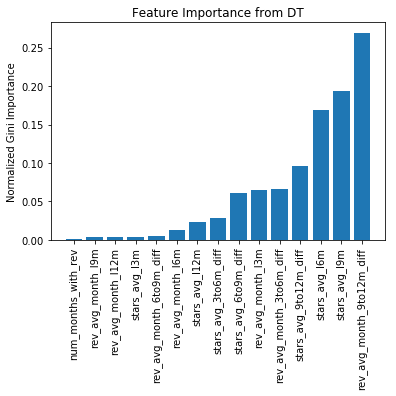

In [256]:
fig, ax = plt.subplots()
imp = clf.feature_importances_
idx = imp.argsort()
ax.bar(np.arange(len(imp)), imp[idx])
ax.set_xticks(np.arange(len(imp)))
ax.set_xticklabels(X_test.columns[idx], rotation=90)
ax.set_ylabel('Normalized Gini Importance')
ax.set_title('Feature Importance from DT')
plt.show()

### 12-04-18
- feature engineering - create diff between stars_avg, rev_avg features
- cross validation code
- model validation - ROC curve with AUC?

### 12-06-18
- set up cross validation
- grid search
- auc curve
- generate latest predictions
    - list of top restaurants for next twelve months. 


this model can be run every month. generates ~50 restaurants per year

In [6]:
data_prepped = pd.read_csv('data_prepped.csv', index_col=0)
data_prepped.head()

,business_id,open_date,target,num_months_with_rev,stars_avg_l12m,stars_avg_l9m,stars_avg_l6m,stars_avg_l3m,rev_avg_month_l12m,rev_avg_month_l9m,rev_avg_month_l6m,rev_avg_month_l3m
0,-01XupAWZEXbdNbxNg5mEg,2009-09-01,0,5,3.250000,3.250000,2.000000,2.000000,0.666667,0.444444,0.166667,0.333333
1,-0WegMt6Cy966qlDKhu6jA,2013-04-01,0,9,2.285714,2.090909,2.000000,2.333333,1.750000,1.222222,0.666667,1.000000
2,-1UMR00eXtwaeh59pEiDjA,2014-03-01,0,12,3.836066,4.065217,4.027778,4.187500,5.083333,5.111111,6.000000,5.333333
3,-4TMQnQJW1yd6NqGRDvAeA,2012-09-01,0,12,4.214286,4.382353,4.205128,4.095238,8.166667,7.555556,6.500000,7.000000
4,-6h3K1hj0d4DRcZNUtHDuw,2009-05-01,0,12,3.407407,3.421053,3.692308,4.000000,2.250000,2.111111,2.166667,2.333333


#### cross validation model

In [257]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

  

In [258]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

for train_index, test_index in skf.split(X_train, y_train):
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    min_leaf=20
    clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_leaf)
    clf.fit(X_train_cv, y_train_cv)
    print('min_samples_leaf: {}'.format(min_leaf))
    print(clf.score(X_test_cv,y_test_cv))

min_samples_leaf: 20
0.917012448133
min_samples_leaf: 20
0.906639004149
min_samples_leaf: 20
0.908713692946
min_samples_leaf: 20
0.902489626556
min_samples_leaf: 20
0.920833333333


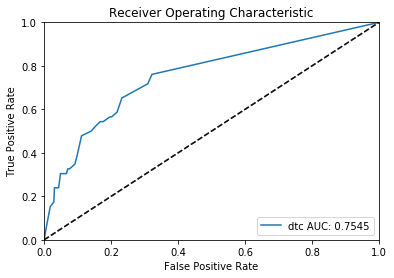

In [259]:
from sklearn.metrics import roc_curve, auc

models = [clf]
models_l = ['dtc']

for i, model in enumerate(models):
    predict = model.predict_proba(X_test)
    fpr, tpr, thres = roc_curve(y_test, predict[:,1])
    auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=(models_l[i] + ' AUC: {:2.4f}'.format(auc)))

plt.plot([[0,0],[1,1]], 'k--', label='', alpha=.75)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### cross validation & grid search

In [260]:
kfolds = StratifiedKFold(n_splits=5)
#1st, set up a paramater grid
param_grid_lr = {'C':[10**i for i in range(-3, 3)], 'penalty':['l1', 'l2']}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv = kfolds, scoring = 'roc_auc') 
lr_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = lr_grid_search.best_score_
print(best_1)

#Next let's look at the best-estimator chosen to see what the parameters were
lr_grid_search.best_estimator_

0.828570960561


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [261]:
# 1 std rule 
best_1 = lr_grid_search.best_score_
std = lr_grid_search.cv_results_['std_test_score'][lr_grid_search.best_index_] 
best_within_1std = min(lr_grid_search.cv_results_['mean_test_score'][lr_grid_search.cv_results_['mean_test_score'] > 
                                             (best_1 - std)])
idx_best_within_1std = np.argwhere(lr_grid_search.cv_results_['mean_test_score'] == best_within_1std)[0][0]
print(best_1)
print(best_within_1std)
print(lr_grid_search.cv_results_['params'][idx_best_within_1std])

0.828570960561
0.812165864211
{'C': 0.1, 'penalty': 'l1'}


In [262]:
kfolds = StratifiedKFold(n_splits=5)
#1st, set up a paramater grid
param_grid_dt = {'min_samples_leaf':[2**i for i in range(0, 6)], 'min_samples_split':[2**i for i in range(1, 6)]}

#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = dt_grid_search.best_score_
print(best_1)

#Next let's look at the best-estimator chosen to see what the parameters were
dt_grid_search.best_estimator_

0.762729491969


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=32,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [263]:
# 1 std rule 
best_1 = dt_grid_search.best_score_
std = dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_] 
best_within_1std = min(dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.cv_results_['mean_test_score'] > 
                                             (best_1 - std)])
idx_best_within_1std = np.argwhere(dt_grid_search.cv_results_['mean_test_score'] == best_within_1std)[0][0]
print(best_1)
print(best_within_1std)
print(dt_grid_search.cv_results_['params'][idx_best_within_1std])

0.762729491969
0.755320544143
{'min_samples_leaf': 32, 'min_samples_split': 32}


#### best to use scaler for SVM since it's a distance based algo

In [264]:
from sklearn.svm import SVC

kfolds = StratifiedKFold(n_splits=5)
#1st, set up a paramater grid
# param_grid_svm = {'C': [1, 10, 100, 1000], 'kernel': ['linear'], 'probability':[True]}
param_grid_svm = {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf'], 'probability':[True]}
# param_grid_svm = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# SVC
#2nd, call the GridSearchCV class, use LogisticRegression and 'roc_auc' for scoring
svm_grid_search = GridSearchCV(SVC(probability=True), param_grid_svm, cv = kfolds, scoring = 'roc_auc') 
svm_grid_search.fit(X_train, y_train)

#3rd, get the score of the best model and print it
best_1 = svm_grid_search.best_score_
print(best_1)

#Next let's look at the best-estimator chosen to see what the parameters were
print(svm_grid_search.best_estimator_)

0.779198139683
SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [265]:
svm_grid_search.cv_results_['mean_test_score']

array([ 0.68434653,  0.6133399 ,  0.68560546,  0.66826615,  0.71193273,
        0.7055482 ,  0.67534126,  0.77077136,  0.69350032,  0.77919814])

In [266]:
# 1 std rule 
best_1 = svm_grid_search.best_score_
std = svm_grid_search.cv_results_['std_test_score'][svm_grid_search.best_index_] 
best_within_1std = min(svm_grid_search.cv_results_['mean_test_score'][svm_grid_search.cv_results_['mean_test_score'] > 
                                             (best_1 - std)])
idx_best_within_1std = np.argwhere(svm_grid_search.cv_results_['mean_test_score'] == best_within_1std)[0][0]
print(best_1)
print(best_within_1std)
print(svm_grid_search.cv_results_['params'][idx_best_within_1std])

0.779198139683
0.770771363958
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True}


### logistic regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create a set of steps. All but the last step is a transformer (something that processes data). 
#Build a list of steps, where the first is StandardScaler and the second is LogisticRegression
#The last step should be an estimator.

steps = [('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

#Now set up the pipeline
pipeline = Pipeline(steps)

#Now set up the parameter grid, paying close to the correct convention here
parameters_scaler = dict(lr__C = [10**i for i in range(-3, 3)],
                  lr__penalty = ['l1', 'l2'])

#Now run another grid search
lr_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'roc_auc')
lr_grid_search_scaler.fit(X, Y)


#Again, print the score of the best model
best_2 = lr_grid_search_scaler.best_score_
print(best_2)

In [267]:
baseline = LogisticRegression()
baseline.fit(X_train, y_train)
lr = LogisticRegression(C=0.1, penalty='l1')
lr.fit(X_train, y_train)
dt = DecisionTreeClassifier(min_samples_leaf=32, min_samples_split=32)
dt.fit(X_train, y_train)
svm = SVC(C=1000, gamma=0.0001, kernel='rbf', probability=True)
svm.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

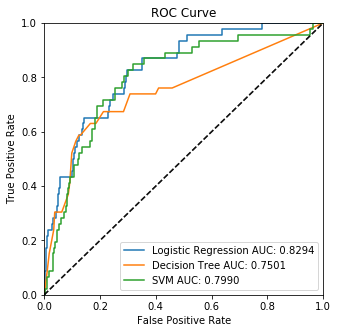

In [320]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(5,5))
# models = [lr_grid_search, dt_grid_search, svm_grid_search]
models = [lr, dt, svm]
models_l = ['Logistic Regression', 'Decision Tree', 'SVM']

for i, model in enumerate(models):
    predict = model.predict_proba(X_test)
    fpr, tpr, thres = roc_curve(y_test, predict[:,1])
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=(models_l[i] + ' AUC: {:2.4f}'.format(auc_score)))

plt.plot([[0,0],[1,1]], 'k--', label='', alpha=.75)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('roc_curve')

### 12-07-18
- run model to get results for next twelve months
    - open date is 2017-04-01, but full year is 2017-05-01 to 2018-04-01

In [ ]:
# 
open_business = revCount[revCount.open_date>='2017-04-01'] # makes sure that actual open date is within dataset
# does not include open date since it could be partial month
open_business_firstyr = open_business[(open_business.date>open_business.open_date) & (open_business.date<=open_business.open_date+pd.DateOffset(years=1))]
# open_business_secondyr = open_business[(open_business.date>open_business.open_date+pd.DateOffset(years=1)) & (open_business.date<=open_business.open_date+pd.DateOffset(years=2))]
display(open_business_firstyr.head(1))

In [220]:
open_business_firstyr = pd.read_csv('open_business_firstyr.csv', index_col=0)
open_business_firstyr.date = pd.to_datetime(open_business_firstyr.date)
open_business_firstyr.open_date = pd.to_datetime(open_business_firstyr.open_date)
open_business_firstyr.head()


,business_id,month,year,rev_count,stars_month_avg,stars_sum,day,date,months_with_rev,business_rev_count,open_date
404,-3vXcKzJA_kVZDM8Yn3w_Q,4,2018,1,5.0,5,1,2018-04-01,2,2,2017-10-01
1265,-CBZRTYGcksmshymcD5iMA,2,2018,2,5.0,10,1,2018-02-01,3,7,2017-11-01
1267,-CBZRTYGcksmshymcD5iMA,12,2017,2,5.0,10,1,2017-12-01,3,7,2017-11-01
3052,-UXH_mn5SLip3MMiaGM69g,4,2018,1,3.0,3,1,2018-04-01,3,4,2017-04-01
3053,-UXH_mn5SLip3MMiaGM69g,8,2017,1,5.0,5,1,2017-08-01,3,4,2017-04-01


In [221]:
dataset = open_business_firstyr
dataset = dataset.reset_index(drop=True)

In [287]:
# add features on final dataset above
# get models trained
# load results dataset
# predict
X_results_full = pd.read_csv('data_prepped_results.csv', index_col=0)
X_results = X_results_full.drop(['open_date','business_id'],1)
X_results.head()

,num_months_with_rev,stars_avg_l12m,stars_avg_l9m,stars_avg_l6m,stars_avg_l3m,rev_avg_month_l12m,rev_avg_month_l9m,rev_avg_month_l6m,rev_avg_month_l3m,stars_avg_3to6m_diff,stars_avg_6to9m_diff,stars_avg_9to12m_diff,rev_avg_month_3to6m_diff,rev_avg_month_6to9m_diff,rev_avg_month_9to12m_diff
0,2,5.000000,5.000000,5.000000,5.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.333333
1,2,4.400000,4.400000,4.400000,4.400000,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1.250000
2,3,4.733333,4.733333,4.733333,4.733333,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-2.500000
3,2,2.862069,2.862069,2.862069,2.862069,2.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-2.416667
4,9,4.261905,4.416667,4.214286,3.750000,3.500000,2.666667,2.333333,1.333333,-0.464286,-0.202381,0.154762,-1.0,-0.333333,-0.833333


In [270]:
X_results.shape

(546, 15)

In [276]:
baseline.predict(X_results)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

### baseline (logistic reg) results (>30% probability) - none were flagged as positive

In [281]:
np.sort(baseline.predict_proba(X_results)[:,1])

array([  1.82697893e-12,   7.71147356e-10,   1.94271236e-08,
         1.98133187e-08,   3.67045556e-08,   1.13748624e-07,
         1.97019725e-07,   4.57166851e-07,   3.84421749e-06,
         4.95093592e-06,   5.09962489e-06,   6.93282283e-06,
         2.21470418e-05,   2.41267179e-05,   3.20135775e-05,
         6.62155718e-05,   9.30141830e-05,   1.00734501e-04,
         1.07121961e-04,   1.22257472e-04,   1.29027355e-04,
         1.34299408e-04,   1.34464650e-04,   1.56376883e-04,
         1.72254613e-04,   2.00859009e-04,   2.36566620e-04,
         2.62903399e-04,   2.63438005e-04,   2.83407499e-04,
         3.29007408e-04,   3.31418994e-04,   3.43729179e-04,
         3.51176313e-04,   3.71183786e-04,   3.77918830e-04,
         3.82512832e-04,   4.17020542e-04,   5.03476508e-04,
         5.12530040e-04,   5.40638823e-04,   6.01470141e-04,
         6.34584525e-04,   6.62129743e-04,   6.69863868e-04,
         8.06126887e-04,   8.15024335e-04,   8.23533748e-04,
         8.39948393e-04,

In [288]:
idx = np.argwhere(baseline.predict_proba(X_results)[:,1] > .3)

In [293]:
idx[0], idx.T[0]

(array([302], dtype=int64), array([302, 431, 496], dtype=int64))

In [296]:
X_list = X_results_full.iloc[idx.T[0],:]

In [314]:
AZrest[AZrest.business_id.isin(X_list['business_id'])].to_csv('rec_list.csv')

In [315]:
X_results_full[X_results_full.business_id.isin(X_list['business_id'])].to_csv('rec_list_details.csv')

### decision tree results

In [311]:
idx = np.argwhere(dt.predict(X_results) == 1)

In [312]:
X_list_dt = X_results_full.iloc[idx.T[0],:]
AZrest[AZrest.business_id.isin(X_list_dt['business_id'])]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,state,stars_avg
1182,"101 N 1st Ave, Ste 115","{'BusinessAcceptsBitcoin': 'False', 'BusinessA...",mhjSXQR9LvL10SSHH6aHIg,"Restaurants, Mexican, Beer Bar, Spanish, Cafes...",Phx,"{'Monday': '7:0-10:0', 'Tuesday': '7:0-10:0', ...",1,33.449835,-112.074699,M'OlÃ©,,85003,14,AZ,4.0
1528,"681 E Apache Blvd, Ste 107","{'Alcohol': 'none', 'Ambience': '{'romantic': ...",NVvjplHvDAoMOEGbYws4Sw,"Mediterranean, Sandwiches, Turkish, Restaurant...",Tempe,"{'Monday': '11:0-2:0', 'Tuesday': '11:0-2:0', ...",1,33.414206,-111.928926,Doner Dudes,,85281,37,AZ,4.0
6185,1712 E Broadway,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",eZqoDfBg-xOS8WdcZCYM2A,"Restaurants, Smokehouse, Food, Barbeque, Sandw...",Phoenix,"{'Monday': '11:0-16:0', 'Tuesday': '11:0-18:0'...",1,33.406990,-112.044537,JL Smokehouse,,85040,56,AZ,5.0
6367,"7051 E 5th Ave, Ste I","{'Alcohol': 'none', 'Ambience': '{'romantic': ...",YoDLrSlxF-ofSvuJTK9fzw,"Waffles, Coffee & Tea, Restaurants, Food, Brea...",Scottsdale,"{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ...",1,33.497470,-111.929602,Berdena's,,85251,129,AZ,4.5
7136,"100 Easy St, Ste 2","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",nDI9Je_wNqNKAntnDXfknA,"Desserts, Italian, Salad, Restaurants, Special...",Carefree,"{'Tuesday': '17:0-21:0', 'Wednesday': '17:0-21...",1,33.824101,-111.922719,Corrado's Cucina Italiana,,85377,57,AZ,4.0
7179,1080 E Pecos Rd,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",3FKALmSFRxaTt60y6d4R_A,"Chicken Wings, Pizza, Salad, Restaurants",Chandler,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1,33.292822,-111.821728,Buon Padre Pizza,,85225,54,AZ,4.5
7205,"2235 S Power Rd, Ste 118","{'Alcohol': 'none', 'Ambience': '{'romantic': ...",uNQFbFnQK-a68S1ktfD_yQ,"Chicken Wings, Pizza, Restaurants, Sandwiches,...",Mesa,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,33.374975,-111.687152,Rosati's Pizza,,85209,104,AZ,4.5


In [313]:
X_results_full[X_results_full.business_id.isin(X_list_dt['business_id'])]

,business_id,open_date,num_months_with_rev,stars_avg_l12m,stars_avg_l9m,stars_avg_l6m,stars_avg_l3m,rev_avg_month_l12m,rev_avg_month_l9m,rev_avg_month_l6m,rev_avg_month_l3m,stars_avg_3to6m_diff,stars_avg_6to9m_diff,stars_avg_9to12m_diff,rev_avg_month_3to6m_diff,rev_avg_month_6to9m_diff,rev_avg_month_9to12m_diff
28,3FKALmSFRxaTt60y6d4R_A,2017-05-01,11,4.600000,4.666667,4.722222,4.000000,3.333333,3.000000,3.000000,1.333333,-0.722222,0.055556,0.066667,-1.666667,0.000000,-0.333333
211,NVvjplHvDAoMOEGbYws4Sw,2017-04-01,10,3.766667,4.000000,4.411765,4.125000,2.500000,2.777778,2.833333,2.666667,-0.286765,0.411765,0.233333,-0.166667,0.055556,0.277778
302,YoDLrSlxF-ofSvuJTK9fzw,2017-04-01,12,4.757576,4.782051,4.788462,4.709677,8.250000,8.666667,8.666667,10.333333,-0.078784,0.006410,0.024476,1.666667,0.000000,0.416667
352,eZqoDfBg-xOS8WdcZCYM2A,2017-06-01,9,4.973684,4.965517,4.960000,5.000000,3.166667,3.222222,4.166667,1.333333,0.040000,-0.005517,-0.008167,-2.833333,0.944444,0.055556
426,mhjSXQR9LvL10SSHH6aHIg,2017-04-01,7,4.250000,4.400000,4.166667,4.000000,1.000000,1.111111,1.000000,1.333333,-0.166667,-0.233333,0.150000,0.333333,-0.111111,0.111111
431,nDI9Je_wNqNKAntnDXfknA,2017-04-01,11,4.255814,4.485714,4.391304,4.526316,3.583333,3.888889,3.833333,6.333333,0.135011,-0.094410,0.229900,2.500000,-0.055556,0.305556
496,uNQFbFnQK-a68S1ktfD_yQ,2017-04-01,11,4.519481,4.583333,4.571429,4.740741,6.416667,6.666667,8.166667,9.000000,0.169312,-0.011905,0.063853,0.833333,1.500000,0.250000


decision tree had 7 results with positive. logistic regression had 0 results. We choose top 3 probability (>30%) from logistic regression and saw that they matched with decision tree results. Here are the top 3 restaurants we would recommend publisher to visit and write about. 


